In [1]:
using Random, PyPlot, LinearAlgebra, Statistics, DataFrames, FITSIO, FITSTables, CSV, PyCall, JLD2

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/aw/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
include("get_lamost_spectra.jl")
LogNorm = pyimport("matplotlib.colors").LogNorm
include("../cats/human_readable_names.jl")
include("figures.jl")
include("model.jl")
;

┌ Info: Precompiling Interpolations [a98d9a8b-a2ab-59e6-89dd-64a1c18fca59]
└ @ Base loading.jl:1273


# prep data

In [3]:
wl_grid = load("wl_grid.jld2")["wl_grid"];

In [4]:
Random.seed!(0)
ntest = 1000
test_obsids = rand(FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5-v3-stellar.fits.gz").obsid, ntest);
download_lamost_spectra(test_obsids);
test_spectra = []
test_ivar = []
for obsid in test_obsids
    wl, flux, ivar = load_lamost_spectrum(obsid, L=25)
    push!(test_spectra, flux)
    push!(test_ivar, ivar)
end

;

of 1000 spectra, 0 need to be downloaded


In [6]:
#rf_obsids = CSV.read("./random.csv").obsid;
#Random.seed!(12345)
#rf_obsids = rand(FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5-v3-stellar.fits.gz").obsid, 30000);
#download_lamost_spectra(rf_obsids; verbose=false)
#
#rf_spectra = []
##rf_ivar = []
#bad_obsids = []
#for obsid in rf_obsids
#    try
#        wl, flux, ivar = load_lamost_spectrum(obsid, L=25)
#        push!(rf_spectra, flux)
#        #push!(rf_ivar, ivar)
#    catch
#        println(obsid)
#        push!(bad_obsids, obsid)
#    end
#end
#rf_spectra = transpose(reduce(hcat, rf_spectra))
##rf_ivar = transpose(reduce(hcat, rf_ivar))
#;

of 30000 spectra, 0 need to be downloaded


In [8]:
#using JLD2, FileIO
#@save "random_30000_rf_spectra.jld2" rf_spectra rf_obsids

In [10]:
using JLD2, FileIO
@load "random_30000_rf_spectra.jld2"

2-element Array{Symbol,1}:
 :rf_spectra
 :rf_obsids 

In [6]:
#whiten spectra
#typical_uncertainty = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar)];
#error = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar)];
#plot(wl_grid, typical_uncertainty)
#
#rf_spectra .-= 1
#rf_spectra ./= typical_uncertainty'
#rf_ivar .*= typical_uncertainty'.^2
#test_spectra = [(f .- 1)./typical_uncertainty for f in test_spectra]
#test_ivar = [iv .* typical_uncertainty.^2 for iv in test_ivar]
#;

# compare old and new methods

  0.881365 seconds (1.42 M allocations: 466.165 MiB, 10.42% gc time)


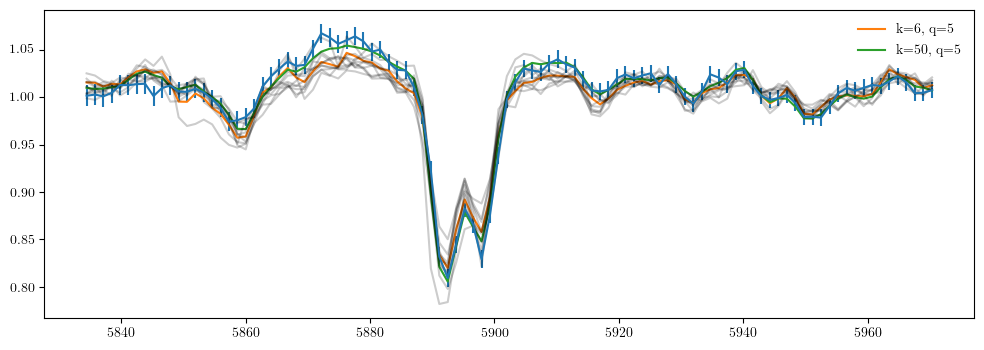

  0.406393 seconds (112 allocations: 428.749 MiB, 7.41% gc time)


PyObject <matplotlib.legend.Legend object at 0x14d41fb38>

In [223]:
include("model.jl")

maskfrac = 0.1
k = 10
q = 5

rf_set = rf_spectra

f, ivar = rand(collect(zip(test_spectra, test_ivar)))
mask = rand(size(rf_spectra, 2)) .< maskfrac


figure(figsize=(12, 4))
pltmask = 1750:1850
errorbar(wl_grid[pltmask], f[pltmask], yerr=ivar[pltmask].^(-1/2))
pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar, 6, 5, mask)
plot(wl_grid[pltmask], pf[pltmask], label="k=6, q=5")
pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar, 500, 50, mask)
plot(wl_grid[pltmask], pf[pltmask], label="k=50, q=5")

σ = ivar.^(-1/2)
σ[σ .== Inf] .= 1.
neighbors = find_neighbors(f[.! mask], rf_spectra[:, .! mask], k)
plot(wl_grid[pltmask], rf_spectra[neighbors, pltmask]', c="k", alpha=0.2)
legend()

# parameter study

In [116]:
include("model.jl")
function MSE(rf_spectra, rf_ivar, test_spectra, test_ivar, k, q; maskfrac = 0.1)
    Random.seed!(2)
    
    MSE = map(collect(zip(test_spectra, test_ivar))[1:100]) do (f, ivar)
        masksize = 100
        npix = size(rf_spectra, 2)
        ind = rand(1 : npix-100)
        mask = ind .<= (1:npix) .<= ind + 100
        
        
        pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar, k, q, mask)
        #dists = map(eachrow(rf_spectra)) do rf_spec                                                  
        #    sum((f[.! mask] .- rf_spec[.! mask]).^2 .* ivar[.! mask])
        #end 
        #dists = sum((rf_spectra[:, .! mask] .- f[.!mask]').^2, dims=2)[:] #.* ivar[.! mask]', dims=2)[:]
        #dists = sum((rf_spectra[:, .! mask] .- f[.!mask]').^2 .* ivar[.! mask]', dims=2)[:]
        #F = rf_spectra[partialsortperm(dists, 1:k), :]
        #pf = project_onto_local_manifold(F, f, ivar, mask, q)
        
        #ivar = copy(ivar)
        #σ = ivar.^(-1/2)
        #σ[σ .== Inf] .= 1.
        #
        #neighbors = find_neighbors(f, σ, rf_spectra', zeros(size(rf_ivar')), k)
        #F = rf_spectra[neighbors, :] 
        #error = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar[neighbors, :])];
        #pf = project_onto_local_manifold((F .- 1)./error', (f.-1)./error, ivar.*error.^2, mask, q) .* error .+ 1
        #pf = project_onto_local_manifold(F, f, ivar, mask, q)
        
        #figure(figsize=(12, 4))
        #errorbar(wl_grid[mask], f[mask], yerr=ivar[mask].^(-1/2))
        #plot(wl_grid[mask],pf[mask])
        #plot(wl_grid[mask],F[:, mask]', c="k", alpha=0.1)
        #figure(figsize=(12, 3))
        #plot(wl_grid,f)
        #plot(wl_grid,pf)
        #plot(wl_grid,F', c="k", alpha=0.1)
        
        mean((pf[mask] - f[mask]).^2 .* ivar[mask])
    end
    mean(MSE)
end
#@time MSE(rf_spectra, rf_ivar, test_spectra, test_ivar, 10, 5)

MSE (generic function with 1 method)

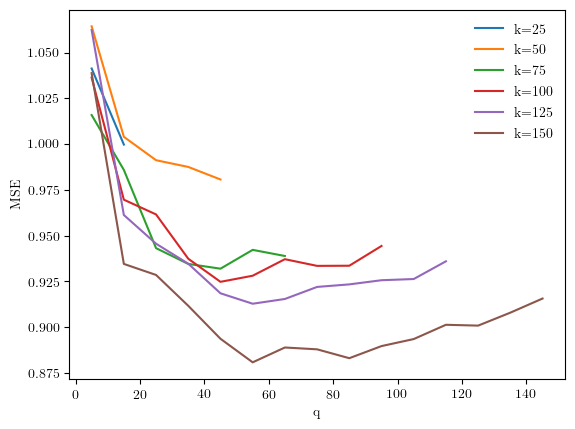

6050.987212 seconds (4.29 M allocations: 4.111 TiB, 4.12% gc time)


In [117]:
@time for k in 25:25:150
    qs = collect(5:10:k-1)
    MSEs = [MSE(rf_spectra, rf_ivar, test_spectra, test_ivar, k, q) for q in qs]
    plot(qs, MSEs, label="k=$k")
end
xlabel("q")
ylabel("MSE")
legend()
savefig("../../Desktop/MSEq.pdf")

In [ ]:
@time for k in 100:100:500
    qs = collect(5:25:k-1)
    MSEs = [MSE(rf_spectra, rf_ivar, test_spectra, test_ivar, k, q) for q in qs]
    plot(qs, MSEs, label="k=$k")
end
xlabel("q")
ylabel("MSE")
legend()
savefig("../../Desktop/MSEq.pdf")

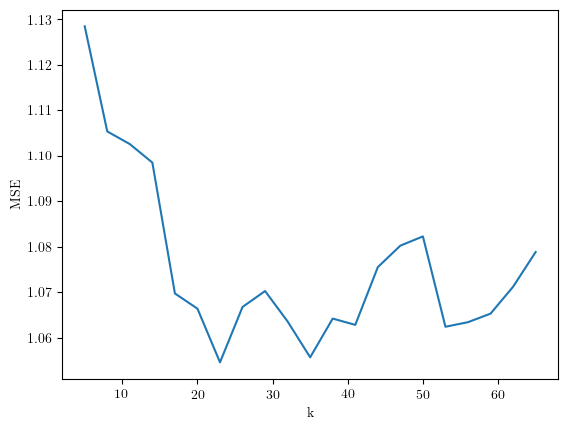

430.572324 seconds (2.80 M allocations: 503.370 GiB, 9.23% gc time)


PyObject Text(22.299550986642977, 0.5, 'MSE')

In [61]:
include("model.jl")
q = 4
ks = 5:3:65
@time MSEs = map(ks) do k
    MSE(rf_spectra, rf_ivar, test_spectra, test_ivar, k, q)
end
plot(ks, MSEs) 
xlabel("k")
ylabel("MSE")

# test Li outliers with large $k, q$

In [7]:
#using CSV
#outliers = CSV.read("distributed_topsnr_1000_test.flagged.csv");

In [124]:
#download_lamost_spectra(outliers.obsid)
#
#outlier_spectra = []
#outlier_ivar = []
#for obsid in outliers.obsid
#    wl, flux, ivar = load_lamost_spectrum(obsid; clip=false)
#    push!(outlier_spectra, flux)
#    push!(outlier_ivar, ivar)
#end
#;

of 760 spectra, 0 need to be downloaded


In [65]:
Δλ = 7
li_air = 6707.85
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ;

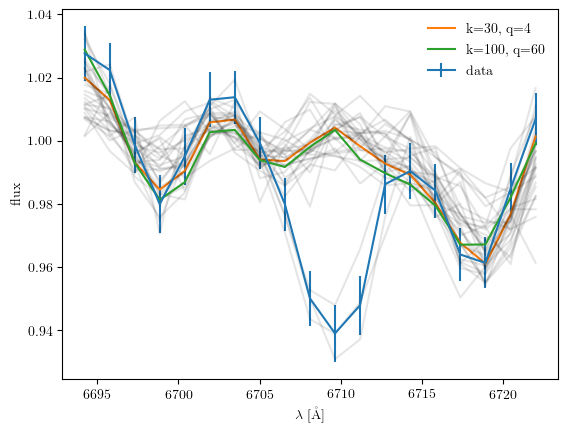

In [111]:
k, q = 30, 4
wl, f, ivar = load_lamost_spectrum(191906235, L=25)
pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar, k, q, line_mask)
pltmask = li_air-15 .< wl_grid .<  li_air + 15
errorbar(wl_grid[pltmask], f[pltmask], yerr=ivar[pltmask].^(-1/2), label="data")
plot(wl_grid[pltmask], pf[pltmask], label="k=30, q=4")

neighbors = find_neighbors(f[.! line_mask], rf_spectra[:, .! line_mask], k)
plot(wl_grid[pltmask], rf_spectra[neighbors, pltmask]', c="k", alpha=0.1)

pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar, 100, 60, line_mask)
plot(wl_grid[pltmask], pf[pltmask], label="k=100, q=60")
legend()

xlabel(L"$\lambda$ [\AA]")
ylabel("flux")
savefig("../../Desktop/hiqloq.pdf")

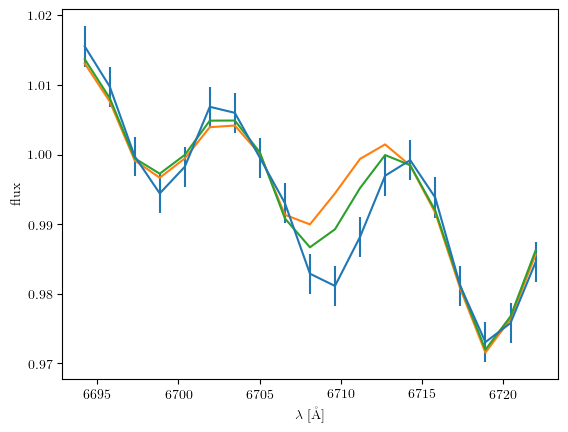

In [115]:
wl, f, ivar = load_lamost_spectrum(446104245, L=25)
pltmask = li_air-15 .< wl_grid .<  li_air + 15

errorbar(wl_grid[pltmask], f[pltmask], yerr=ivar[pltmask].^(-1/2), label="data")

k, q = 3000, 1000
pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar, k, q, line_mask)
plot(wl_grid[pltmask], pf[pltmask], label="masked")

pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar, k, q, wl_grid .< 0)
plot(wl_grid[pltmask], pf[pltmask], label="unmasked")

#neighbors = find_neighbors(f[.! line_mask], rf_spectra[:, .! line_mask], k)
#plot(wl_grid[pltmask], rf_spectra[neighbors, pltmask]', c="k", alpha=0.01)


xlabel(L"$\lambda$ [\AA]")
ylabel("flux")
savefig("../../Desktop/hiqloq.pdf")